# 19. [Clustering 集群](https://github.com/joelgrus/data-science-from-scratch/blob/master/code/clustering.py)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
from __future__ import division
from linear_algebra import squared_distance, vector_mean, distance
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from pprint import pprint

In [9]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],
          [11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

In [4]:
class KMeans:
    """performs k-means clustering"""

    def __init__(self, k):
        self.k = k          # number of clusters 分成多少個群組
        self.means = None   # means of clusters  各群組平均值
        

    def train(self, inputs):
    
        self.means = random.sample(inputs, self.k)  # 隨意取 k 個樣本作為初始平均值
        assignments = None  # 群組歸屬
        
        while True:
            # Find new assignments
            # 使用 classify 重新計算，找出各點的群組歸屬
            new_assignments = list(map(self.classify, inputs))

            # If no assignments have changed, we're done.  # 群組歸屬不再變動時，代表訓練結束
            if assignments == new_assignments:                
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments 
            
            # 益算各個群組的平均值
            # 每次有新的點加入或移出一個群組，該群組的重心（平均值）都會移動
            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]  # 抓出特定群組的 points
                # avoid divide-by-zero if i_points is empty
                if i_points:                                
                    self.means[i] = vector_mean(i_points)  # 該特定群組的 elementwise平均值
                    
        
    def classify(self, input):
        """return the index of the cluster closest to the input"""
        # 依據 inputs 距離那一個 平均值 較近，來判斷 input 的群組歸屬
        return min(range(self.k), key=lambda i: squared_distance(input, self.means[i]))

In [5]:
# 每個點離群組中心點的 距離平方和

def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means  # 集群中的 k個平均值
    assignments = map(clusterer.classify, inputs)  # 集群中每個點的群組歸屬
    
    return sum(squared_distance(input, means[cluster])  # 每個點離群組中心點的 距離平方和
               for input, cluster in zip(inputs, assignments))

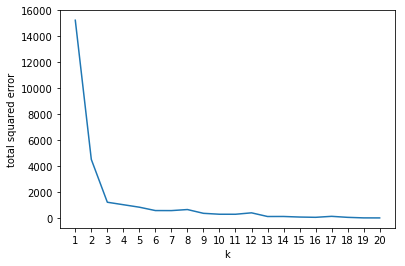

In [10]:
# 每個點離群組中心點的 距離平方和
# 
def plot_squared_clustering_errors(plt):

    ks = range(1, len(inputs) + 1)
    errors = [squared_clustering_errors(inputs, k) for k in ks]

    plt.plot(ks, errors)
    plt.xticks(ks)
    plt.xlabel("k")
    plt.ylabel("total squared error")
    plt.show()
    
plot_squared_clustering_errors(plt)

# 劃分為三個群組的時候，平均誤差距離會大幅度縮小，而且群組數量少，較易於管理

In [7]:
print("errors as a function of k")

for k in range(1, len(inputs) + 1):
    print(k, squared_clustering_errors(inputs, k))    

errors as a function of k
1 15241.35
2 4508.738095238095
3 1209.0555555555557
4 1209.0555555555557
5 999.7222222222223
6 584.5
7 533.6666666666666
8 400.1666666666667
9 411.0
10 171.16666666666666
11 288.91666666666663
12 133.83333333333331
13 74.83333333333333
14 114.0
15 124.0
16 33.5
17 67.0
18 15.0
19 8.5
20 0.0


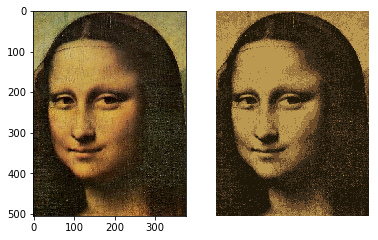

In [8]:
#
# using clustering to recolor an image
#

def recolor_image(input_file, k=5):

    img = mpimg.imread(input_file)
    plt.subplot(121).imshow(img)
    pixels = [pixel for row in img for pixel in row]
    clusterer = KMeans(k)
    clusterer.train(pixels) # this might take a while    

    def recolor(pixel):
        cluster = clusterer.classify(pixel) # index of the closest cluster
        return clusterer.means[cluster]     # mean of the closest cluster

    new_img = [[recolor(pixel) for pixel in row]
               for row in img]

    plt.subplot(122).imshow(new_img)
    plt.axis('off')
    plt.show()
    
recolor_image('vinci.png')    

In [18]:
#
# hierarchical clustering
#

def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

def cluster_distance(cluster1, cluster2, distance_agg=min):
    """finds the aggregate distance between elements of cluster1
    and elements of cluster2"""
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]
    
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda x: cluster_distance(x[0], x[1], distance_agg))

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]
    
    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [19]:
def plot_inputs(inputs):
    x = [e[0] for e in inputs]
    y = [e[1] for e in inputs]
    plt.scatter(x, y) 

3-means: [[-25.857142857142854, -4.714285714285714], [20.0, 26.0], [16.666666666666664, 13.666666666666666]]


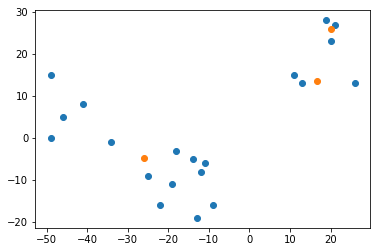

In [13]:
random.seed(0) # so you get the same results as me
clusterer = KMeans(3)
clusterer.train(inputs)
means = clusterer.means
print("3-means:", means)
plot_inputs(inputs) 
plot_inputs(means)

2-means: [[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]


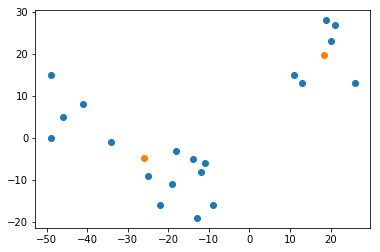

In [14]:
random.seed(0)
clusterer = KMeans(2)
clusterer.train(inputs)
means = clusterer.means
print("2-means:", means)
plot_inputs(inputs) 
plot_inputs(means) 

In [23]:
print("bottom up hierarchical clustering")

base_cluster = bottom_up_cluster(inputs)
pprint(base_cluster)

bottom up hierarchical clustering
(0,
 [(1,
   [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]),
    (16, [([11, 15],), ([13, 13],)])]),
  (2,
   [(4,
     [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]),
      ([-34, -1],)]),
    (6,
     [(7,
       [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]),
        (13,
         [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]),
          ([-18, -3],)])]),
      (12, [([-13, -19],), ([-9, -16],)])])])])


three clusters, min:
[[11, 15], [13, 13], [26, 13], [19, 28], [21, 27], [20, 23]]
[[-41, 8], [-49, 15], [-49, 0], [-46, 5], [-34, -1]]
[[-11, -6],
 [-12, -8],
 [-14, -5],
 [-18, -3],
 [-22, -16],
 [-19, -11],
 [-25, -9],
 [-13, -19],
 [-9, -16]]


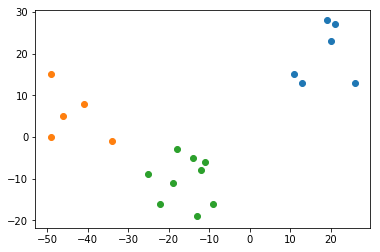

In [30]:
print("three clusters, min:")
for cluster in generate_clusters(base_cluster, 3):
    pprint(get_values(cluster)) 
    plot_inputs(get_values(cluster))     

three clusters, max:
[[11, 15], [13, 13], [26, 13], [19, 28], [21, 27], [20, 23]]
[[-41, 8], [-49, 15], [-49, 0], [-46, 5], [-34, -1]]
[[-11, -6],
 [-12, -8],
 [-14, -5],
 [-18, -3],
 [-22, -16],
 [-19, -11],
 [-25, -9],
 [-13, -19],
 [-9, -16]]


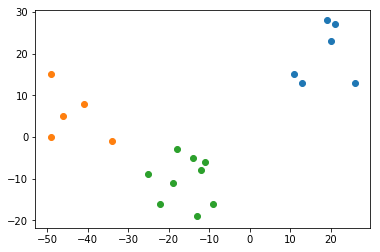

In [31]:
print("three clusters, max:")
base_cluster = bottom_up_cluster(inputs, max)
for cluster in generate_clusters(base_cluster, 3):
    pprint(get_values(cluster))
    plot_inputs(get_values(cluster))     